## Binance top 200 coins by volume and momentum

In [60]:
coins = 200

## 1- Obtengo la data usando la API de Binance

In [61]:
import requests
import pandas as pd
from datetime import datetime, timedelta

def get_top_volume_coins_list_api(count=200):
    # Obtener la lista de todos los símbolos de trading
    symbols_url = "https://api.binance.com/api/v3/exchangeInfo"
    symbols_response = requests.get(symbols_url)
    symbols_data = symbols_response.json()
    
    # Filtrar solo los pares con USDT
    usdt_symbols = [symbol['symbol'] for symbol in symbols_data['symbols'] if symbol['symbol'].endswith('USDT')]

    # Elimino las stablecoins
    stablecoins = ['USDCUSDT', 'FDUSDUSDT', '1000SATS', '1000SATSBTC', 'WBTC']
    usdt_symbols = [symbol for symbol in usdt_symbols if symbol not in stablecoins]
    
    # Calcular la fecha de inicio (7 días atrás)
    start_time = int((datetime.now() - timedelta(days=7)).timestamp() * 1000)
    
    # Obtener el volumen para cada símbolo
    volumes = []
    for symbol in usdt_symbols:
        klines_url = f"https://api.binance.com/api/v3/klines?symbol={symbol}&interval=1d&startTime={start_time}"
        klines_response = requests.get(klines_url)
        klines_data = klines_response.json()
        
        # Calcular el volumen promedio
        total_volume = sum(float(kline[7]) for kline in klines_data) #7 es quote asset volume
        avg_volume = total_volume / len(klines_data) if klines_data else 0
        volumes.append((symbol[:-4], avg_volume))  # Removemos 'USDT' del símbolo
    
    # Ordenar por volumen descendente y tomar los primeros 'count'
    top_volumes = sorted(volumes, key=lambda x: x[1], reverse=True)[:count]
    
    return top_volumes  # Ahora retornamos la lista completa de tuplas (moneda, volumen)

def get_top_volume_coins_df_api(count=200):
    volumes = get_top_volume_coins_list_api(count)
    df = pd.DataFrame(volumes, columns=['coin', 'average volume last 7 days'])

    # Ordenar el DataFrame antes de formatear los números
    df = df.sort_values('average volume last 7 days', ascending=False)

   # Formatear los números después de ordenar
    df['average volume last 7 days'] = df['average volume last 7 days'].apply(lambda x: f'{x:.2f}')

    return df

In [62]:
api_top_coins_list = get_top_volume_coins_list_api(coins)
#api_top_coins_list

In [63]:
api_top_coins_df = get_top_volume_coins_df_api(coins)
api_top_coins_df

,coin,average volume last 7 days
0,BTC,1263760981.19
1,ETH,487533885.77
2,SOL,296646260.28
3,PEPE,111138367.82
4,WIF,89650234.79
...,...,...
195,NEO,1514724.20
196,MTL,1508324.03
197,XEC,1503739.94
198,KLAY,1502970.93


#### Conclusion
Mejor uso el API directamente, ya que evito que CS50 tenga que instalar un paquete adicional de python. 

Las variables que pasan a la siguiente etapa son: 


api_top_coins_df 

api_top_coins_list

Trabajare con la lista pero primero tengo que eliminar los valores de volumen, que hago a continuacion

In [64]:
# Get the ticker list for coins.
top_coins = [item[0] for item in api_top_coins_list]
top_coins

['BTC',
 'ETH',
 'SOL',
 'PEPE',
 'WIF',
 'SUI',
 'BNB',
 'XRP',
 'DOGS',
 'FET',
 '1000SATS',
 'AAVE',
 'DOGE',
 'TON',
 'TRX',
 'FTM',
 'PEOPLE',
 'AVAX',
 'ORDI',
 'BOME',
 'NEAR',
 'RUNE',
 'FLOKI',
 'LTC',
 'STRK',
 'NOT',
 'SEI',
 'CRV',
 'ADA',
 'ARB',
 'ENA',
 'WLD',
 'ICP',
 'BONK',
 'TAO',
 'EUR',
 'DAR',
 'SAGA',
 'RENDER',
 'PENDLE',
 'EURI',
 'LINK',
 'SUN',
 'INJ',
 'ZRO',
 'OP',
 'SHIB',
 'APE',
 'AR',
 'TIA',
 'BNX',
 'IO',
 'RARE',
 'FIL',
 'APT',
 'UNI',
 'LUNA',
 'GALA',
 'JUP',
 'ATOM',
 'CKB',
 'MATIC',
 'MKR',
 'BCH',
 'ARKM',
 'GMT',
 'ETHFI',
 'SUPER',
 'DOT',
 'ENS',
 'STX',
 'ZK',
 'OM',
 'RDNT',
 'JASMY',
 'BB',
 'BANANA',
 'QUICK',
 'LUNC',
 'TRB',
 'DYDX',
 'TKO',
 'EOS',
 'LDO',
 'MANTA',
 'COTI',
 'HARD',
 'JTO',
 'RPL',
 'VIDT',
 'VOXEL',
 'RSR',
 'LOKA',
 'AEVO',
 'ALT',
 'PIXEL',
 'AERGO',
 'ASTR',
 'BTTC',
 'CVC',
 '1INCH',
 'AI',
 'VIC',
 'SSV',
 'XAI',
 'REZ',
 'COMP',
 'ETC',
 'ARPA',
 'BEAMX',
 'BLUR',
 'BSW',
 'HBAR',
 'MBOX',
 'ELF',
 'MEME',
 '

## 2- Obtener klines para cada criptomoeda

#### USANDO EL WRAPER

In [73]:
# Obtiene klines con la lista top_coins, el par BTC y el par USDT
# FUNCION QUE USA EL WRAPER
import pandas as pd
from binance.client import Client
from datetime import datetime, timedelta, timezone
import os


client = Client()

not_available_btcpair = []
# FUNCION PARA BTC PAIRS
def get_klines_btcpair_wraper(crypto_list, weeks_back: int):
    """    
    weeks_back: int -> Indica la cantidad de semanas atras a considerar. 0 para esta semana, 1 para la semana anterior, etc.
    """
    today = datetime.now(timezone.utc)  # Asegurarse de trabajar en UTC
    
    # Calcular el lunes de la semana actual
    monday_this_week = today - timedelta(days=today.weekday())

    # Obtener la fecha del lunes de la semana objetivo y convertir a 00:00 en UTC
    target_monday = monday_this_week - timedelta(weeks=weeks_back)
    target_monday_at_midnight = target_monday.replace(hour=0, minute=0, second=0, microsecond=0)

    # Obtener la fecha del domingo de la semana objetivo y convertir a 00:00 en UTC
    target_sunday = target_monday + timedelta(days=6)
    target_sunday_at_midnight = target_sunday.replace(hour=0, minute=0, second=0, microsecond=0)    

    # Retornar como timestamp en UTC en str
    start_timestamp = str(target_monday_at_midnight.timestamp())
    print(f"Start timestamp: {start_timestamp}")

    end_timestamp = str(target_sunday_at_midnight.timestamp())
    print(f"End timestamp: {end_timestamp}")


    dataframes = []

    # Crear la carpeta 'data' si no existe
    if not os.path.exists('data'):
        os.makedirs('data')

    for crypto in crypto_list:
        try:
            print(f"Fetching data for {crypto}BTC...")
            klines = client.get_historical_klines(
                symbol=f"{crypto}BTC", # for BTC pairs
                #symbol=f"{crypto}USDT", # for USDT pairs
                interval=Client.KLINE_INTERVAL_1DAY,
                start_str=start_timestamp,
                end_str=end_timestamp,
            )
            print (klines)

            # Crear el DataFrame
            df = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
            
            # Convertir el timestamp a datetime
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            
            # Establecer el timestamp como índice
            df.set_index('timestamp', inplace=True)
            
            # Convertir las columnas necesarias a float
            for col in ['open', 'high', 'low', 'close', 'volume']:
                df[col] = df[col].astype(float)
            
            # Guardar el DataFrame como CSV
            filename = f"data/{crypto}BTC.csv"
            df.to_csv(filename)
            
            dataframes.append(df)
            print(f"Datos de {crypto} guardados en {filename}")

        except Exception as e:
            print(f"Error al obtener datos para {crypto}BTC.")
            print(e)
            not_available_btcpair.append(crypto)
            continue

    return dataframes

#ejemplo de uso
#dataframes = get_klines_btcpair_wraper(top_coins, 1)

#### USANDO LA API PELADA

In [74]:
# Obtiene klines con la lista top_coins, el par BTC y el par USDT
# FUNCION QUE USA EL WRAPER
import pandas as pd
from binance.client import Client
from datetime import datetime, timedelta, timezone
import os


client = Client()

not_available_btcpair = []
# FUNCION PARA BTC PAIRS
def get_klines_btcpair(crypto_list, weeks_back: int):
    """    
    weeks_back: int -> Indica la cantidad de semanas atras a considerar. 0 para esta semana, 1 para la semana anterior, etc.
    """
    today = datetime.now(timezone.utc)  # Asegurarse de trabajar en UTC
    
    # Calcular el lunes de la semana actual
    monday_this_week = today - timedelta(days=today.weekday())

    # Obtener la fecha del lunes de la semana objetivo y convertir a 00:00 en UTC
    target_monday = monday_this_week - timedelta(weeks=weeks_back)
    target_monday_at_midnight = target_monday.replace(hour=0, minute=0, second=0, microsecond=0)

    # Obtener la fecha del domingo de la semana objetivo y convertir a 00:00 en UTC
    target_sunday = target_monday + timedelta(days=6)
    target_sunday_at_midnight = target_sunday.replace(hour=0, minute=0, second=0, microsecond=0)    

    # Retornar como timestamp en UTC en str
    start_timestamp = str(int(target_monday_at_midnight.timestamp()))
    #print(f"Start timestamp: {start_timestamp}")

    end_timestamp = str(int(target_sunday_at_midnight.timestamp()))
    #print(f"End timestamp: {end_timestamp}")


    dataframes = []

    # Crear la carpeta 'data' si no existe
    if not os.path.exists('data'):
        os.makedirs('data')

    for crypto in crypto_list:
        
        print(f"Fetching data for {crypto}BTC...")
        symbol=f"{crypto}BTC" # for BTC pairs
        start_str=start_timestamp+'000'
        #print(start_str)
        end_str=end_timestamp+'000'

        klines_url = f"https://api.binance.com/api/v3/klines?symbol={symbol}&interval=1d&startTime={start_str}&endTime={end_str}"
        print(klines_url)
        klines_response = requests.get(klines_url)
        print(klines_response.status_code)

        if klines_response.status_code == 200:
            print('se obtuvo codigo 200')
            klines_data = klines_response.json()
            if len(klines_data) == 0:
                print(f"No data available for {crypto}BTC")
                not_available_btcpair.append(crypto)
                continue
            print (klines_data)

            # Crear el DataFrame
            df = pd.DataFrame(klines_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
            
            # Convertir el timestamp a datetime
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            
            # Establecer el timestamp como índice
            df.set_index('timestamp', inplace=True)
            
            # Convertir las columnas necesarias a float
            for col in ['open', 'high', 'low', 'close', 'volume']:
                df[col] = df[col].astype(float)
            
            # Eliminar las columnas que no me sirve
            df = df.drop(['close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'], axis=1)

            # Guardar el DataFrame como CSV
            filename = f"data/{crypto}BTC.csv"
            print(filename)
            df.to_csv(filename)
            
            dataframes.append(df)
            print(f"Datos de {crypto} guardados en {filename}")
            print ('-----------------------------------------')
        
        elif klines_response.status_code == 404:
            print(f"Error: {crypto}BTC no está disponible en Binance.")
            print(klines_response.text)
            not_available_btcpair.append(crypto)
            print ('-----------------------------------------')

        elif klines_response.status_code == 400:
            print(f"Error: {crypto}BTC no está disponible en Binance.")
            not_available_btcpair.append(crypto)
            print ('-----------------------------------------')

    return dataframes

#ejemplo de uso
dataframes = get_klines_btcpair(top_coins, 1)

Fetching data for BTCBTC...
https://api.binance.com/api/v3/klines?symbol=BTCBTC&interval=1d&startTime=1725235200000&endTime=1725753600000
400
Error: BTCBTC no está disponible en Binance.
-----------------------------------------
Fetching data for ETHBTC...
https://api.binance.com/api/v3/klines?symbol=ETHBTC&interval=1d&startTime=1725235200000&endTime=1725753600000
200
se obtuvo codigo 200
[[1725235200000, '0.04235000', '0.04340000', '0.04231000', '0.04291000', '21882.97790000', 1725321599999, '938.33287600', 126684, '10502.47060000', '450.14745664', '0'], [1725321600000, '0.04291000', '0.04294000', '0.04204000', '0.04218000', '15037.32130000', 1725407999999, '637.86831894', 83161, '6880.11890000', '291.78855646', '0'], [1725408000000, '0.04219000', '0.04274000', '0.04128000', '0.04226000', '31515.78410000', 1725494399999, '1325.99422403', 142479, '16301.87140000', '686.11354707', '0'], [1725494400000, '0.04226000', '0.04245000', '0.04181000', '0.04216000', '17020.48260000', 17255807999

In [76]:
not_available_btcpair

['BTC',
 'PEPE',
 'DOGS',
 '1000SATS',
 'FLOKI',
 'NOT',
 'BONK',
 'EUR',
 'EURI',
 'SUN',
 'SHIB',
 'LUNA',
 'JUP',
 'CKB',
 'JASMY',
 'QUICK',
 'LUNC',
 'HARD',
 'JTO',
 'RPL',
 'VOXEL',
 'RSR',
 'AERGO',
 'BTTC',
 'CVC',
 'BEAMX',
 'BSW',
 'MEME',
 'CREAM',
 'KEY',
 'G',
 'LISTA',
 'STMX',
 'SYN',
 'USTC',
 'USDP',
 'ALPACA',
 'LEVER',
 'AKRO',
 'RAY',
 'HOT',
 'MASK',
 'BURGER',
 'XEC']

## 3. Data Processing

In [68]:
# Limpiamos el df con solo las columnas que nos interesan

dataframes[0]

,open,high,low,close,volume
timestamp,,,,,
2024-09-02,0.04235,0.04340,0.04231,0.04291,21882.9779
2024-09-03,0.04291,0.04294,0.04204,0.04218,15037.3213
2024-09-04,0.04219,0.04274,0.04128,0.04226,31515.7841
2024-09-05,0.04226,0.04245,0.04181,0.04216,17020.4826
2024-09-06,0.04217,0.04258,0.04085,0.04123,46145.7447
2024-09-07,0.04124,0.04227,0.04123,0.04199,20385.5488
2024-09-08,0.04198,0.04229,0.04175,0.04186,18918.6580


In [79]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

def analyze_crypto_data(data_folder='data'):
    results = []
    
    for filename in os.listdir(data_folder):
        if filename.endswith('.csv'):
            coin = filename.split('.')[0]
            filepath = os.path.join(data_folder, filename)
            
            # Leer el archivo CSV
            df = pd.read_csv(filepath)
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            
            # Calcular el retorno
            first_open = df.iloc[0]['open']
            last_close = df.iloc[-1]['close']
            returns = (last_close - first_open) / first_open * 100
            
            # Preparar datos para la regresión lineal
            X = np.arange(len(df)).reshape(-1, 1)
            y = df['close'].values
            
            # Realizar regresión lineal
            model = LinearRegression()
            model.fit(X, y)
            
            intercept = model.intercept_
            slope = model.coef_[0]
            
            results.append({
                'coin': coin,
                'return': returns,
                'intercept': intercept,
                'slope': slope
            })
            print(f"Análisis para {coin} completado.")
    
    # Crear DataFrame con los resultados
    result_df = pd.DataFrame(results)
    
    # Ordenar por slope de mayor a menor
    result_df = result_df.sort_values('slope', ascending=False)
    
    return result_df

# Ejemplo de uso
df_maestro = analyze_crypto_data()
df_maestro

Análisis para MINABTC completado.
Análisis para HIGHBTC completado.
Análisis para WLDBTC completado.
Análisis para ANKRBTC completado.
Análisis para VIDTBTC completado.
Análisis para VITEBTC completado.
Análisis para CFXBTC completado.
Análisis para AXSBTC completado.
Análisis para BLURBTC completado.
Análisis para WBTCBTC completado.
Análisis para CRVBTC completado.
Análisis para LDOBTC completado.
Análisis para APEBTC completado.
Análisis para BNBBTC completado.
Análisis para COMPBTC completado.
Análisis para LINKBTC completado.
Análisis para YGGBTC completado.
Análisis para SKLBTC completado.
Análisis para ACHBTC completado.
Análisis para SUPERBTC completado.
Análisis para BNXBTC completado.
Análisis para IOBTC completado.
Análisis para OMNIBTC completado.
Análisis para IDEXBTC completado.
Análisis para XLMBTC completado.
Análisis para ZENBTC completado.
Análisis para BANANABTC completado.
Análisis para KSMBTC completado.
Análisis para TRUBTC completado.
Análisis para VICBTC complet

,coin,return,intercept,slope
42,PAXGBTC,4.783809,0.042486,0.000666
13,BNBBTC,2.561235,0.008856,0.000045
9,WBTCBTC,0.030036,0.998682,0.000039
51,QNTBTC,19.299905,0.001022,0.000025
85,BCHBTC,2.016499,0.005408,0.000022
...,...,...,...,...
34,ORDIBTC,15.620181,0.000533,-0.000002
90,EGLDBTC,-4.175365,0.000468,-0.000003
101,TAOBTC,-2.793417,0.004491,-0.000029
82,ETHBTC,-1.157025,0.042573,-0.000163


#### Ploteo de grafica

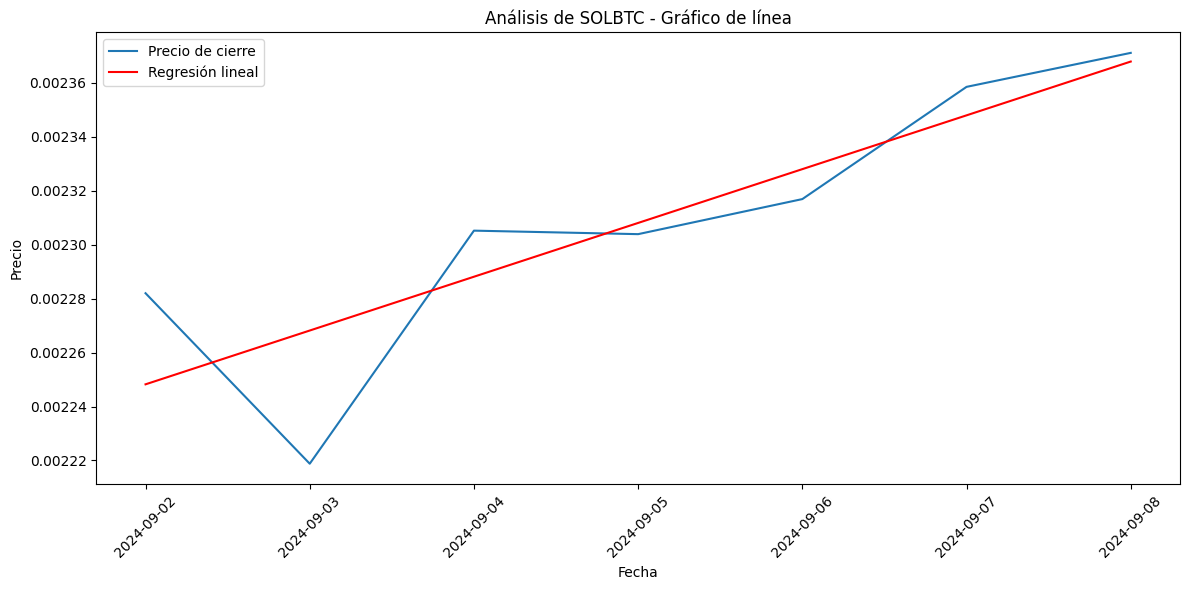

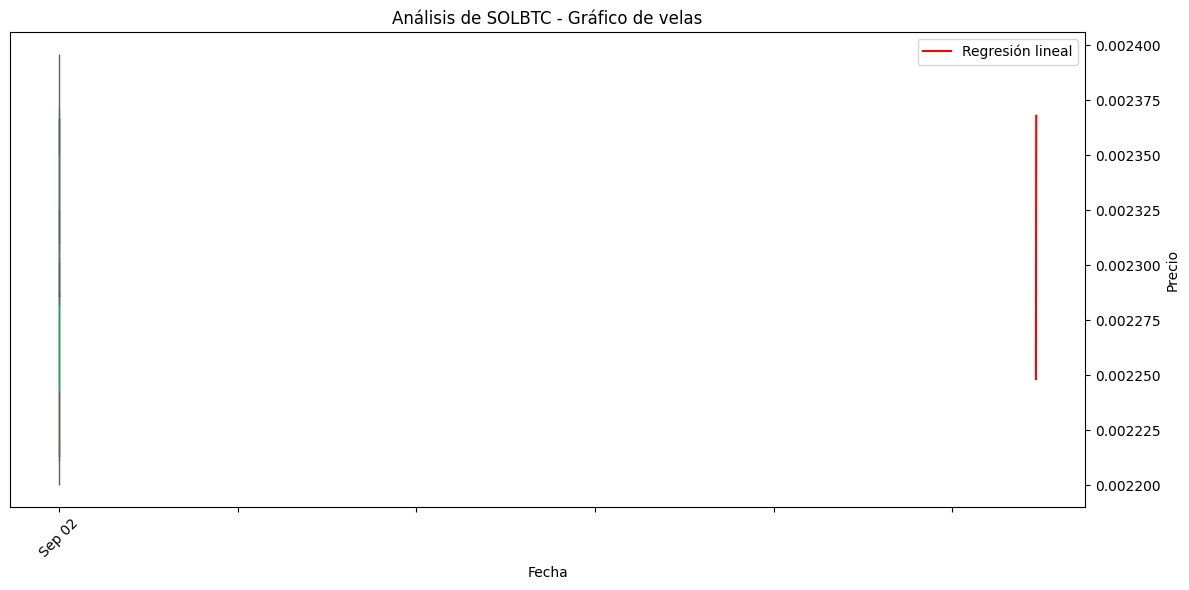

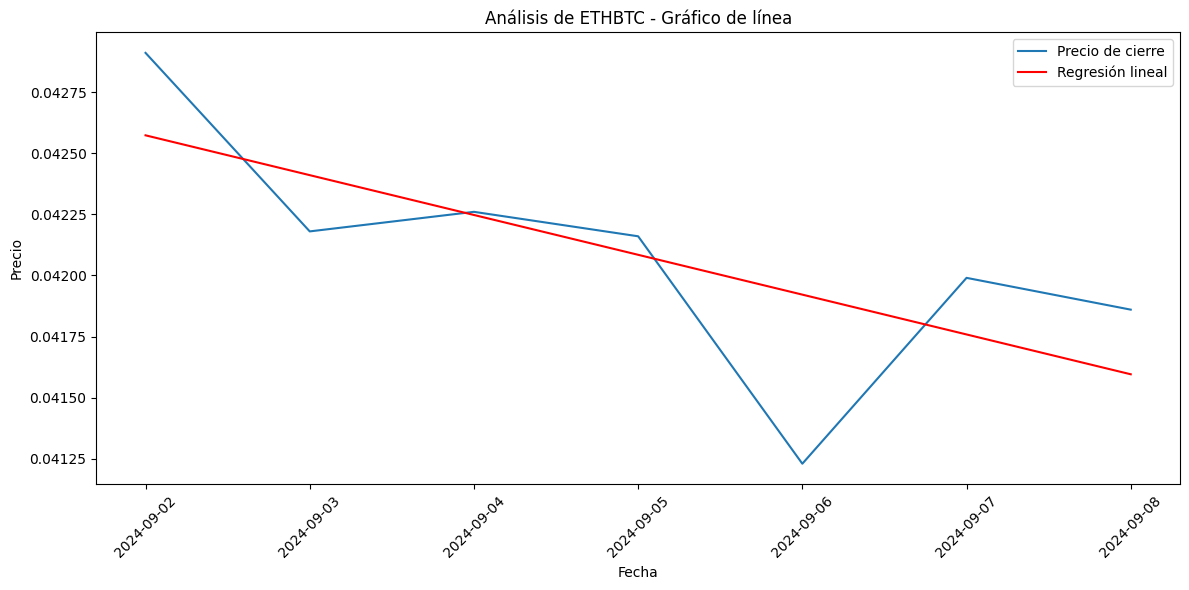

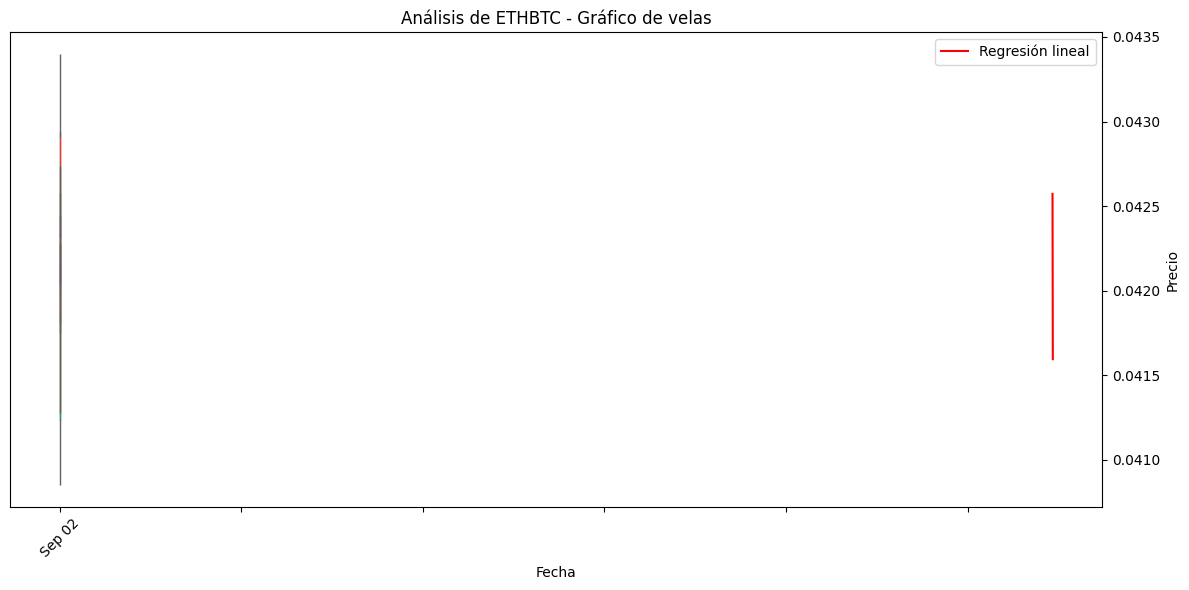

In [ ]:
# Ploteo 1, plotea bien el linechart pero no el candlestick

import os
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf

def plot_crypto_data(df_maestro, data_folder='data', plot_folder='plots'):
    # Crear la carpeta 'plots' si no existe
    if not os.path.exists(plot_folder):
        os.makedirs(plot_folder)

    for _, row in df_maestro.iterrows():
        coin = row['coin']
        slope = row['slope']
        intercept = row['intercept']

        # Leer el archivo CSV correspondiente
        df = pd.read_csv(os.path.join(data_folder, f"{coin}.csv"))
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.set_index('timestamp', inplace=True)

        # Calcular la línea de regresión
        x = range(len(df))
        regression_line = [slope * xi + intercept for xi in x]

        # Gráfico de línea
        plt.figure(figsize=(12, 6))
        plt.plot(df.index, df['close'], label='Precio de cierre')
        plt.plot(df.index, regression_line, label='Regresión lineal', color='red')
        plt.title(f"Análisis de {coin} - Gráfico de línea")
        plt.xlabel("Fecha")
        plt.ylabel("Precio")
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(plot_folder, f"{coin}_line.png"))
        plt.show()

        # Gráfico de velas (candlestick)
        fig, ax = plt.subplots(figsize=(12, 6))
        mpf.plot(df, type='candle', style='yahoo', ax=ax)
        ax.plot(df.index, regression_line, label='Regresión lineal', color='red')
        ax.set_title(f"Análisis de {coin} - Gráfico de velas")
        ax.set_xlabel("Fecha")
        ax.set_ylabel("Precio")
        ax.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(plot_folder, f"{coin}_candlestick.png"))
        plt.show()

# Ejemplo de uso:
#df_maestro = analyze_crypto_data()  # Asumiendo que esta función ya fue definida y ejecutada
#plot_crypto_data(df_maestro)

In [ ]:
# Ploteo 2, plotea mal las velas no suma el slope e intercepto

import os
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf

def plot_crypto_data(df_maestro, data_folder='data', plot_folder='plots'):
    # Crear la carpeta 'plots' si no existe
    if not os.path.exists(plot_folder):
        os.makedirs(plot_folder)

    for _, row in df_maestro.iterrows():
        coin = row['coin']
        slope = row['slope']
        intercept = row['intercept']

        # Leer el archivo CSV correspondiente
        df = pd.read_csv(os.path.join(data_folder, f"{coin}.csv"))
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.set_index('timestamp', inplace=True)

        # Calcular la línea de regresión
        x = range(len(df))
        regression_line = [slope * xi + intercept for xi in x]

        # Gráfico de línea
        plt.figure(figsize=(12, 6))
        plt.plot(df.index, df['close'], label='Precio de cierre')
        plt.plot(df.index, regression_line, label='Regresión lineal', color='red')
        plt.title(f"Análisis de {coin} - Gráfico de línea")
        plt.xlabel("Fecha")
        plt.ylabel("Precio")
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(plot_folder, f"{coin}_line.png"))
        plt.close()

        # Gráfico de velas (candlestick)
        mpf.plot(df, type='candle', style='yahoo', title=f"Análisis de {coin} - Gráfico de velas",
                 ylabel='Precio', ylabel_lower='Volumen',
                 volume=True, figsize=(12, 6),
                 savefig=os.path.join(plot_folder, f"{coin}_candlestick.png"))
        
        # Agregar la línea de regresión al gráfico de velas
        fig, axes = mpf.plot(df, type='candle', style='yahoo', title=f"Análisis de {coin} - Gráfico de velas",
                             ylabel='Precio', ylabel_lower='Volumen',
                             volume=True, figsize=(12, 6),
                             returnfig=True)
        axes[0].plot(df.index, regression_line, color='red', label='Regresión lineal')
        axes[0].legend(['Regresión lineal'])
        plt.savefig(os.path.join(plot_folder, f"{coin}_candlestick_with_regression.png"))
        plt.close()

# Ejemplo de uso:
#df_maestro = analyze_crypto_data()  # Asumiendo que esta función ya fue definida y ejecutada
#plot_crypto_data(df_maestro)